# First Quantization

SELECT and PREPARE for the first quantized chemistry Hamiltonian.

Here we assume the Born-Oppenheimer Hamiltonian and seek to simulate a
collection of $\eta$ electrons and $L$ static nuclei (of charge $\zeta_\ell$)
with a Hamiltonian given by:
$$
H_{BO} = T + U + V + \frac{1}{2}
\sum_{\ell\ne\kappa=1}^L\frac{\zeta_\ell\zeta_\kappa}{\lVert R_\ell - R_\kappa \rVert}
$$

In the first quantized approach we assume periodic boundary conditions and use a
plane wave Galerkin discretization.
A plane wave basis function is given by
$$
\phi_p(r) = \frac{1}{\sqrt{\Omega}} e^{-i k_p\cdot r}
$$
where $r$ is a position vector in real space, $\Omega$ is the simulation cell
volume and $k_p$ is a reciprocal lattice vector.
In three dimensions we have
$$
k_p = \frac{2\pi p }{\Omega}
$$
for $p \in G$ and
$$
G = \left[-\frac{N^{1/3} -
1}{2},\frac{N^{1/3} - 1}{2}\right]^{\otimes 3} \subset \mathbb{Z}^3,
$$
and $N$ is the total number of planewaves.

With these definitions we can write the components of the Hamiltonian as:
$$
T = \sum_{i}^\eta\sum_{p\in G}\frac{\lVert k_p\rVert^2}{2} |p\rangle\langle p|_i
$$
which defines the kinetic energy of the electrons,
$$
U = -\frac{4\pi}{\Omega}
\sum_{\ell=1}^L \sum_{i}^\eta
\sum_{p,q\in G, p\ne q}
\left(
    \zeta_{\ell}
    \frac{e^{i k_{q-p}\cdot R_\ell}}{\lVert k_{p-q}\rVert^2}
    |p\rangle\langle q|_i
\right)
$$
describes the interaction of the electrons and the nuclei, and,
$$
V = \frac{2\pi}{\Omega}
\sum_{i\ne j=1}^\eta
\sum_{p,q\in G, p\ne q}
\sum_{\nu \in G_0}
\left(
    \frac{1}{\lVert k_{\nu}\rVert^2}
    |p + \nu\rangle\langle p|_i
    |q -\nu\rangle\langle q|_i
\right)
$$
describes the electron-electron interaction. The notation $|p\rangle\langle p|_i$ is shorthand for
$I_1\otimes\cdots\otimes |p\rangle \langle p |_j \otimes \cdots \otimes I_\eta$.
The system is represented using a set of $\eta$ signed integer registers each of
size $3 n_p$ where $n_p =  \lceil \log (N^{1/3} + 1) \rceil$, with the factor of
3 accounting for the 3 spatial dimensions.

In the first quantized approach, fermion antisymmetry is encoded through initial
state preparation. Spin labels are also absent and should be accounted for
during state preparation. The cost of initial state preparation is typically
ignored.

In [26]:
from qualtran import Bloq, CompositeBloq, BloqBuilder, Signature, Register
from qualtran.drawing import show_bloq
from typing import *
import numpy as np

## `PrepareTFirstQuantization`
PREPARE for the kinetic energy operator for the first quantized chemistry Hamiltonian.

This prepares the state

$$
    |+\rangle\sum_{j=1}^{\eta}|j\rangle\sum_{w=0}^{2}|w\rangle
    \sum_{r=0}^{n_{p}-2}2^{r/2}|r\rangle
    \sum_{s=0}^{n_{p}-2}2^{s/2}|s\rangle
$$

We assume that the uniform superposition over ($i$ and) $j$ has already occured via
UniformSuperPositionIJFirstQuantization.

#### Parameters
 - `num_bits_p`: The number of bits to represent each dimension of the momentum register.
 - `eta`: The number of electrons.
 - `num_bits_rot_aa`: The number of bits of precision for the single qubit rotation for amplitude amplification. Called $b_r$ in the reference.
 - `adjoint`: whether to dagger the bloq or not. 

#### Registers
 - `plus`: A $|+\rangle$ state register.
 - `w`: a register to index one of three components of the momenta.
 - `r`: a register encoding bits for each component of the momenta.
 - `s`: a register encoding bits for each component of the momenta. 

#### References
[Fault-Tolerant Quantum Simulations of Chemistry in First Quantization]( https://arxiv.org/abs/2105.12767) page 19, section B


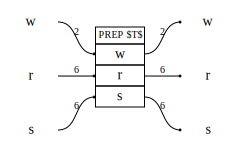

In [27]:
from qualtran.bloqs.chemistry.first_quantization import PrepareTFirstQuantization

num_bits_p = 6
eta = 10
bloq = PrepareTFirstQuantization(num_bits_p, eta)
show_bloq(bloq)

## `SelectTFirstQuantization`
SELECT for the kinetic energy operator for the first quantized chemistry Hamiltonian.

#### Parameters
 - `num_bits_p`: The number of bits to represent each dimension of the momentum register.
 - `eta`: The number of electrons. 

#### Registers
 - `sys`: The system register.
 - `plus`: A $|+\rangle$ state.
 - `flag_T`: a flag to control on the success of the $T$ state preparation. 

#### References
[Fault-Tolerant Quantum Simulations of Chemistry in First Quantization]( https://arxiv.org/abs/2105.12767) page 20, section B


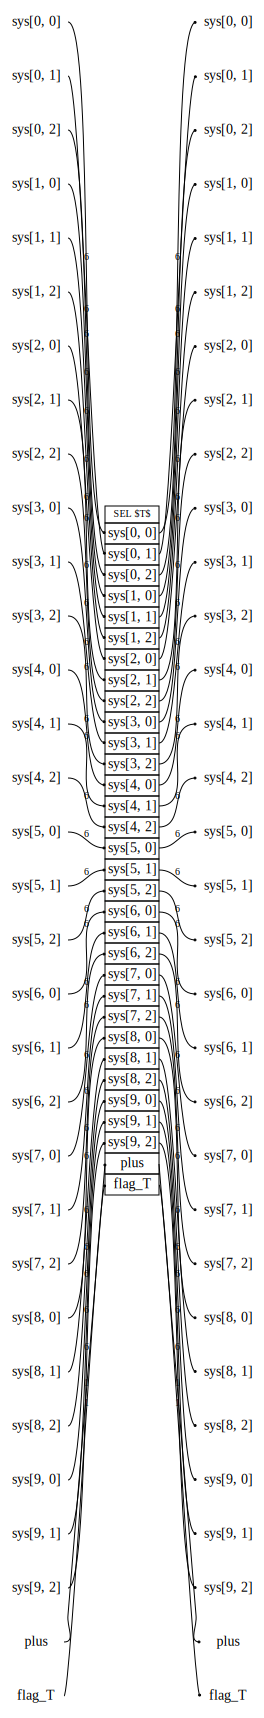

In [28]:
from qualtran.bloqs.chemistry.first_quantization import SelectTFirstQuantization

num_bits_p = 6
eta = 10
bloq = SelectTFirstQuantization(num_bits_p, eta)
show_bloq(bloq)

## `SelectUVFirstQuantization`
SELECT for the U and V operators for the first quantized chemistry Hamiltonian.

This does not include the controlled swaps from p_i and q_j into ancilla registers and back again.

#### Parameters
 - `num_bits_p`: The number of bits to represent each dimension of the momentum register.
 - `eta`: The number of electrons.
 - `num_bits_nuc_pos`: The number of bits to store each component of the nuclear positions. $n_R$ in the reference. 

Registers:

#### References
[Fault-Tolerant Quantum Simulations of Chemistry in First Quantization]( https://arxiv.org/abs/2105.12767)


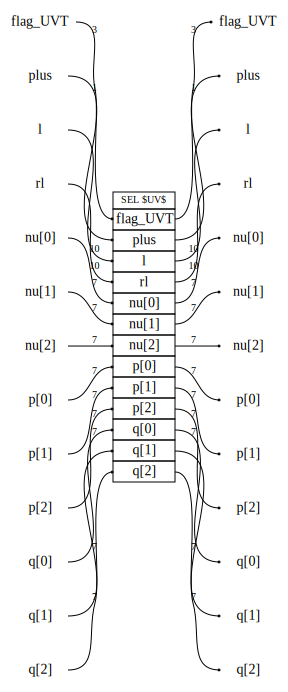

In [29]:
from qualtran.bloqs.chemistry.first_quantization import SelectUVFirstQuantization

num_bits_p = 6
eta = 10
bloq = SelectUVFirstQuantization(num_bits_p, eta, 10)
show_bloq(bloq)

## `PrepareUVFistQuantization`
PREPARE the U and V parts of the Hamiltonian.

#### Parameters
 - `num_bits_p`: The number of bits to represent each dimension of the momentum register.
 - `eta`: The number of electrons.
 - `num_atoms`: The number of atoms. $L$ in the reference.
 - `m_param`: $\mathcal{M}$ in the reference.
 - `lambda_zeta`: sum of nuclear charges.
 - `num_bits_nuc_pos`: The number of bits of precision for representing the nuclear coordinates. 

#### Registers
 - `mu`: The state controlling the nested boxes procedure.
 - `nu`: The momentum transfer register.
 - `m`: an ancilla register in a uniform superposition.
 - `l`: The register for atomic species.
 - `flag_nu`: Flag for success of the state preparation. 

#### References
[Fault-Tolerant Quantum Simulations of Chemistry in First Quantization]( https://arxiv.org/abs/2105.12767) page 19, section B


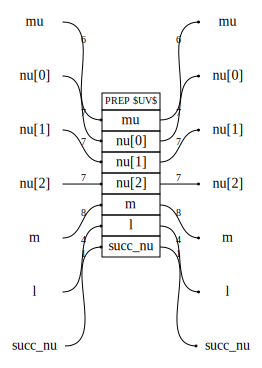

In [30]:
from qualtran.bloqs.chemistry.first_quantization import PrepareUVFistQuantization

num_bits_p = 6
num_atoms = 10
eta = 10
m_param = 2**8
lambda_zeta = 10
num_bits_nuc_pos = 4
prep = PrepareUVFistQuantization(
    num_bits_p, eta, num_atoms, m_param, lambda_zeta, num_bits_nuc_pos
)
bloq = prep
show_bloq(bloq)

## `PrepareNuState`
PREPARE for the $\nu$ state for the $U$ and $V$ components of the Hamiltonian.

Prepares a state of the form

$$
    \frac{1}{\sqrt{\mathcal{M}2^{n_p + 2}}}
    \sum_{\mu=2}^{n_p+1}\sum_{\nu \in B_\mu}
    \sum_{m=0}^{\lceil \mathcal M(2^{\mu-2}/\lVert\nu\rVert)^2\rceil-1}
    \frac{1}{2^\mu}|\mu\rangle|\nu_x\rangle|\nu_y\rangle|\nu_z\rangle|m\rangle|0\rangle
$$

#### Parameters
 - `num_bits_p`: The number of bits to represent each dimension of the momentum register.
 - `m_param`: $\mathcal{M}$ in the reference.
 - `lambda_zeta`: sum of nuclear charges.
 - `er_lambda_zeta`: eq 91 of the referce. Cost of erasing qrom. 

#### Registers
 - `mu`: The state controlling the nested boxes procedure.
 - `nu`: The momentum transfer register.
 - `m`: an ancilla register in a uniform superposition.
 - `flag_nu`: Flag for success of the state preparation. 

#### References
[Fault-Tolerant Quantum Simulations of Chemistry in First Quantization]( https://arxiv.org/abs/2105.12767) page 19, section B


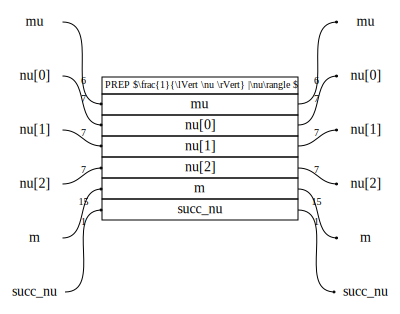

In [31]:
from qualtran.bloqs.chemistry.first_quantization import PrepareNuState

num_bits_p = 6
m_param = 2 ** (2 * num_bits_p + 3)
bloq = PrepareNuState(num_bits_p, m_param)
show_bloq(bloq)

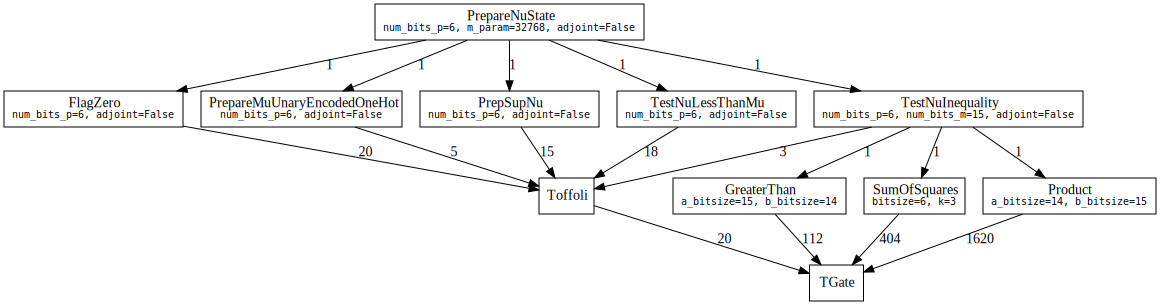

In [32]:
from qualtran.resource_counting import get_bloq_counts_graph
from qualtran.drawing import GraphvizCounts
graph, sigma = get_bloq_counts_graph(bloq)
GraphvizCounts(graph).get_svg()

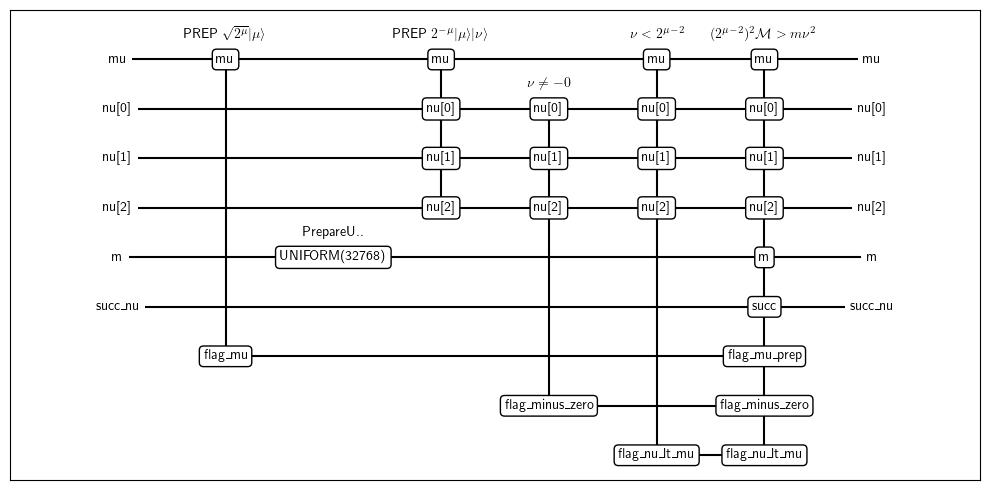

In [33]:
from qualtran.drawing import get_musical_score_data, draw_musical_score, Text
import matplotlib.pyplot as plt

msd = get_musical_score_data(bloq.decompose_bloq())

fig, ax = plt.subplots(figsize=(10, 5))
for hline in msd.hlines:
    ax.hlines(-hline.y, hline.seq_x_start, hline.seq_x_end, color='k', zorder=-1)

for vline in msd.vlines:
    ax.vlines(vline.x, -vline.top_y, -vline.bottom_y, color='k', zorder=-1)
    Text(vline.label).draw(ax, vline.x, vline.bottom_y - 0.5)

for soq in msd.soqs:
    symb = soq.symb
    symb.draw(ax, soq.rpos.seq_x, soq.rpos.y)

plt.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 
ax.set_xlim((-2, msd.max_x + 1))
ax.set_ylim((-msd.max_y - 0.5, 1))
fig.tight_layout()

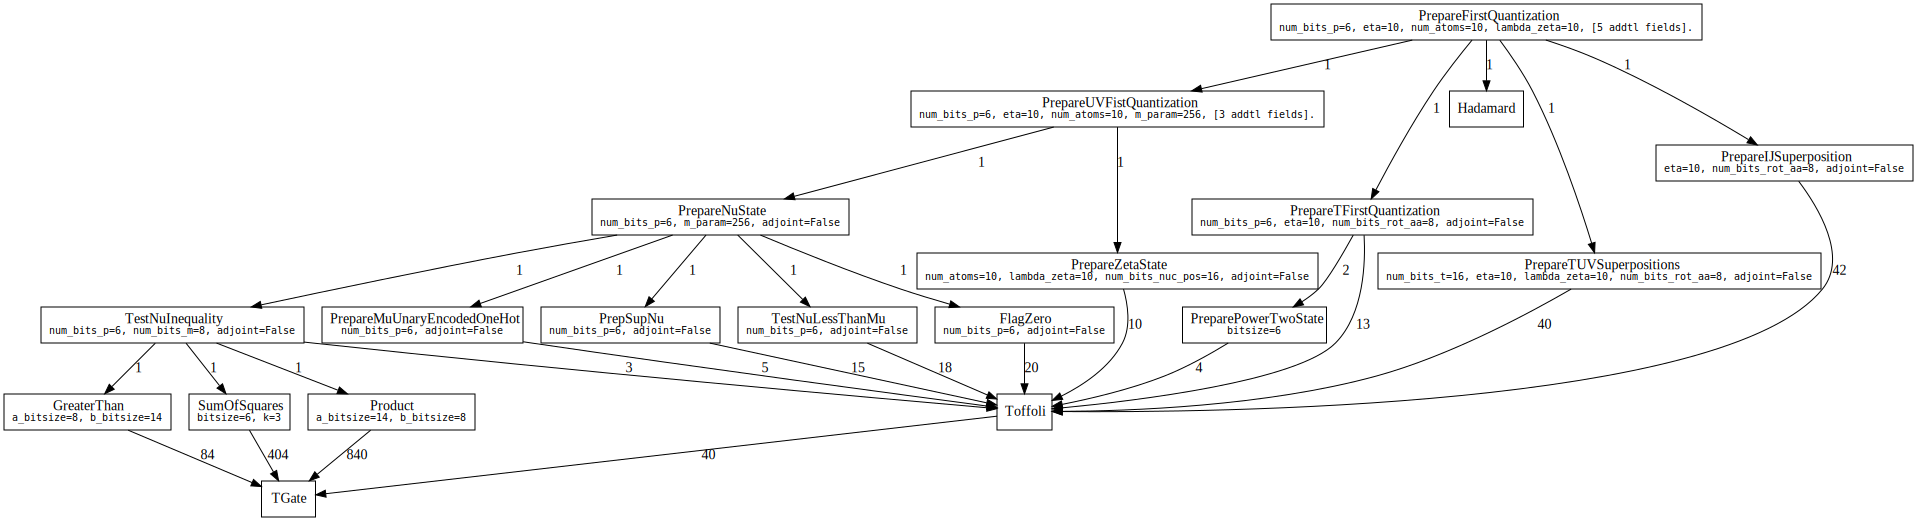

In [34]:
from qualtran.resource_counting import get_bloq_counts_graph
from qualtran.drawing import GraphvizCounts
from qualtran.bloqs.chemistry.first_quantization import PrepareFirstQuantization

num_bits_p = 6
m_param = 2 ** (2 * num_bits_p + 3)
eta = 10
num_atoms = eta
lambda_zeta = eta # hydrogen
bloq = PrepareFirstQuantization(num_bits_p, eta, num_atoms, lambda_zeta)
graph, sigma = get_bloq_counts_graph(bloq)
GraphvizCounts(graph).get_svg()

In [42]:
from qualtran.drawing import get_musical_score_data, draw_musical_score, Text
import matplotlib.pyplot as plt

params= {'text.latex.preamble' : r'\usepackage{amsmath}'}
plt.rcParams.update(params)

def plot_musical_score_mod(bloq, size=(10, 7)):
    msd = get_musical_score_data(bloq.decompose_bloq())

    fig, ax = plt.subplots(figsize=size)
    for hline in msd.hlines:
        ax.hlines(-hline.y, hline.seq_x_start, hline.seq_x_end, color='k', zorder=-1)

    for vline in msd.vlines:
        ax.vlines(vline.x, -vline.top_y, -vline.bottom_y, color='k', zorder=-1)
        Text(vline.label).draw(ax, vline.x, vline.bottom_y - 0.5)

    for soq in msd.soqs:
        symb = soq.symb
        symb.draw(ax, soq.rpos.seq_x, soq.rpos.y)

    plt.tick_params(left = False, right = False , labelleft = False , 
                    labelbottom = False, bottom = False) 
    ax.set_xlim((-2, msd.max_x + 1))
    ax.set_ylim((-msd.max_y - 0.5, 1))
    fig.tight_layout()

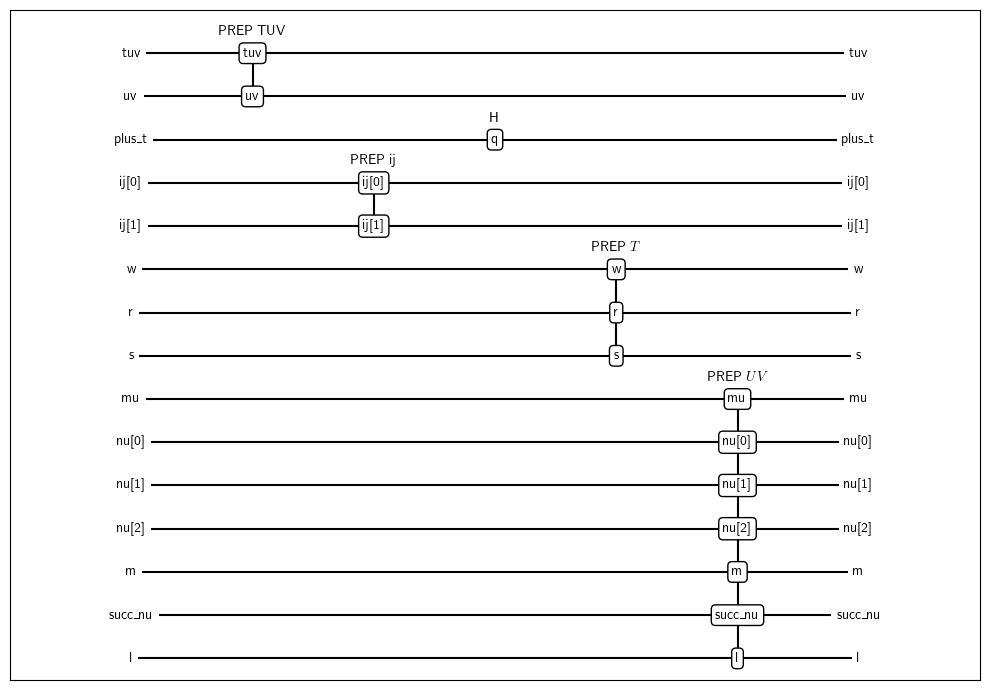

In [36]:
plot_musical_score_mod(bloq)

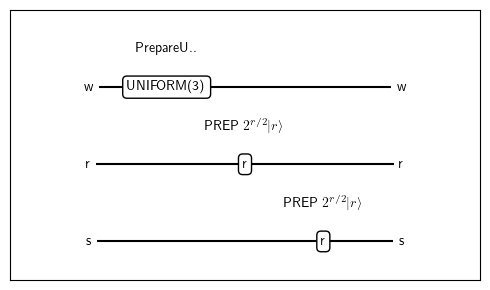

In [43]:
from qualtran.resource_counting import get_bloq_counts_graph
from qualtran.drawing import GraphvizCounts
from qualtran.bloqs.chemistry.first_quantization import PrepareTFirstQuantization

num_bits_p = 6
m_param = 2 ** (2 * num_bits_p + 3)
eta = 10
num_atoms = eta
lambda_zeta = eta # hydrogen
bloq = PrepareTFirstQuantization(num_bits_p, eta)
plot_musical_score_mod(bloq, size=(5, 3))

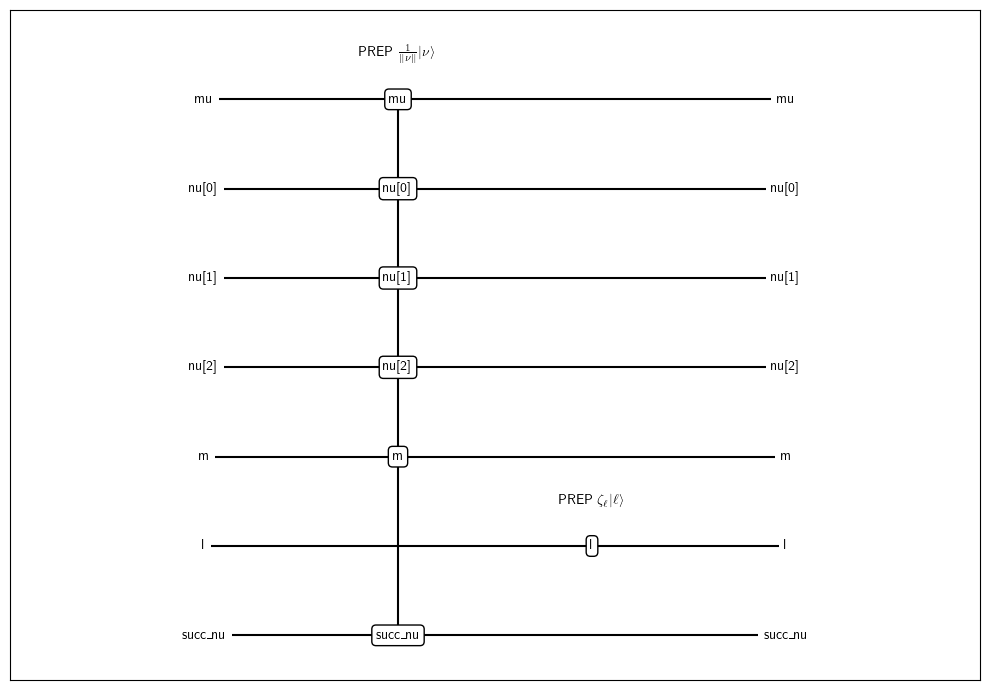

In [38]:
from qualtran.resource_counting import get_bloq_counts_graph
from qualtran.drawing import GraphvizCounts
from qualtran.bloqs.chemistry.first_quantization import PrepareUVFistQuantization 
from qualtran.drawing import show_bloq

num_bits_p = 6
m_param = 2 ** (2 * num_bits_p + 3)
eta = 10
num_atoms = eta
lambda_zeta = eta # hydrogen
num_bits_nuc_pos = 16
bloq = PrepareUVFistQuantization(num_bits_p, eta, num_atoms, 2**8, lambda_zeta, num_bits_nuc_pos)
plot_musical_score_mod(bloq)

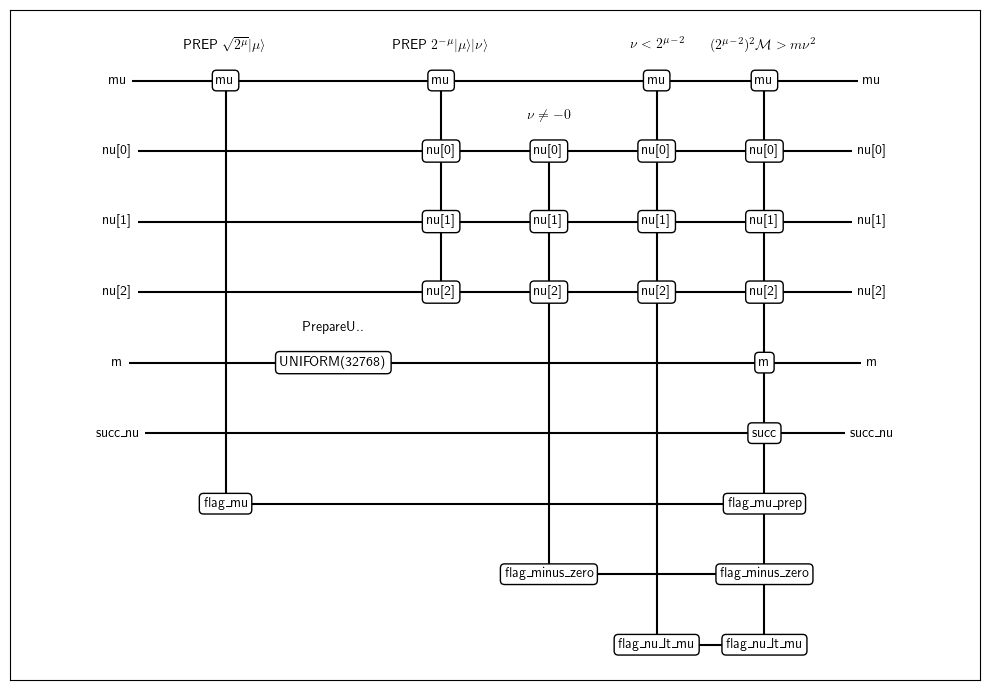

In [39]:
from qualtran.resource_counting import get_bloq_counts_graph
from qualtran.drawing import GraphvizCounts
from qualtran.bloqs.chemistry.first_quantization import PrepareNuState 
from qualtran.drawing import show_bloq

num_bits_p = 6
m_param = 2 ** (2 * num_bits_p + 3)
eta = 10
num_atoms = eta
lambda_zeta = eta # hydrogen
num_bits_nuc_pos = 16
bloq = PrepareNuState(num_bits_p, m_param)
plot_musical_score_mod(bloq)

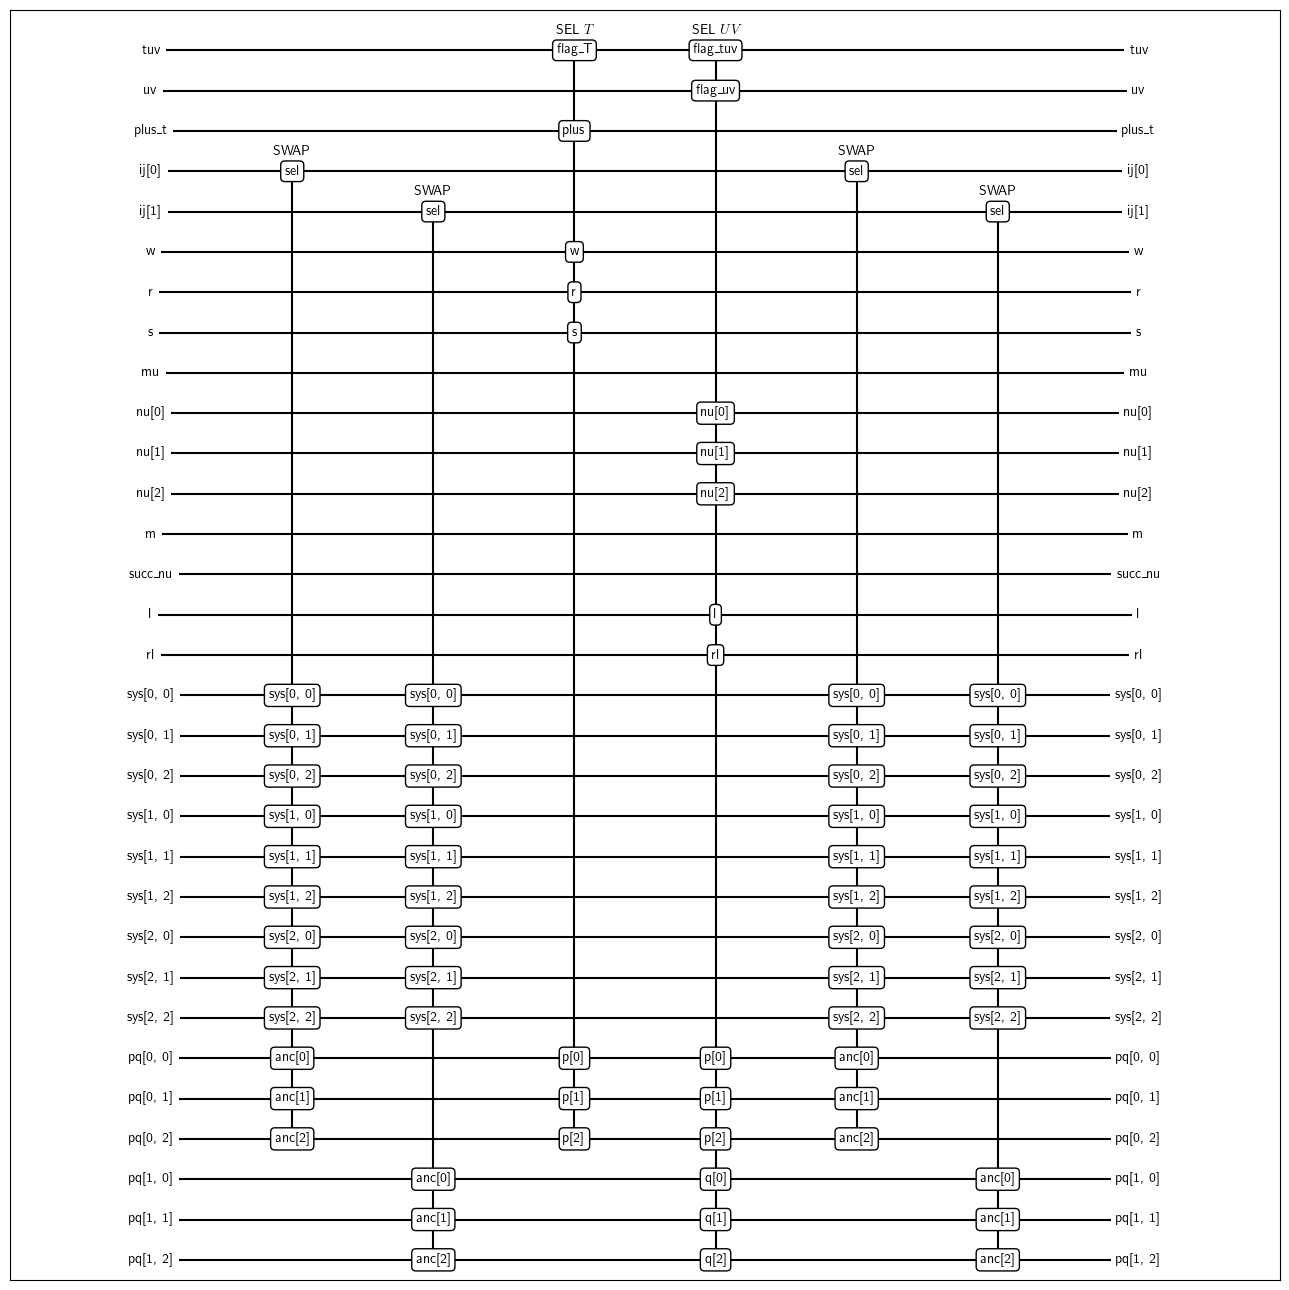

In [59]:
from qualtran.resource_counting import get_bloq_counts_graph
from qualtran.drawing import GraphvizCounts
from qualtran.bloqs.chemistry.first_quantization import SelectFirstQuantization
from qualtran.drawing import show_bloq

num_bits_p = 6
m_param = 2 ** (2 * num_bits_p + 3)
eta = 3
num_atoms = eta
lambda_zeta = eta # hydrogen
num_bits_nuc_pos = 16
bloq = SelectFirstQuantization(num_bits_p, eta, num_atoms, lambda_zeta, m_param)
plot_musical_score_mod(bloq, size=(13, 13))